In [1]:
from rtma.imports import *
from rtma.core import *
from rtma.objects import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *
from rtma.sine_model import *

In [2]:
from pathlib import Path

In [3]:
import librosa as lr

In [4]:
hop_size = 480  # 10ms
frame_size = hop_size * 5 # 50ms 
fft_size = 4096
i = 100

In [5]:
path = Path('~/data/recorded_sounds/stairway_to_heaven_intro.mp3').expanduser()
x, sr = lr.load(path, sr=None)
x.shape, sr

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


((643919,), 48000)

In [6]:
x, _ = lr.effects.trim(x)
x = x[:sr*2]
x.shape

(96000,)

In [7]:
s = Signal("data/E_octaves_both.wav")
s.x = x
s.sample_rate = sr
s.filename = path.name

In [8]:
s.duration

2.0

In [9]:
s.play()

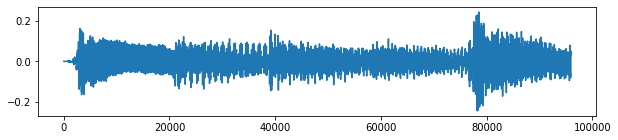

In [10]:
s.plot()

(204,
 Analysis(Signal("stairway_to_heaven_intro.mp3"), frame_size=2400, hop_size=480))

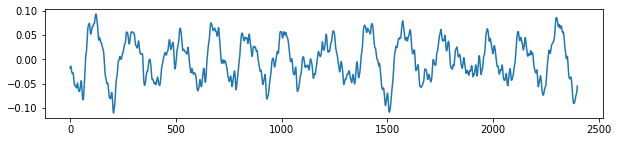

In [11]:
a = Analysis(s, frame_size=frame_size, hop_size=hop_size)
frames = list(a.frames)
frames[i].plot()
len(frames), a

In [12]:
sa = SpectralAnalysis(s, 
                      fft_size=fft_size,
                      window_name='hamming',
                      frame_size=frame_size, 
                      hop_size=hop_size)

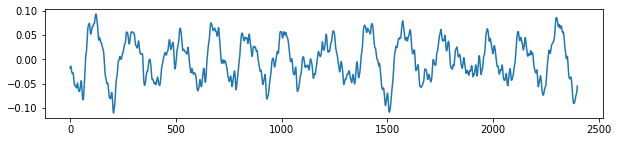

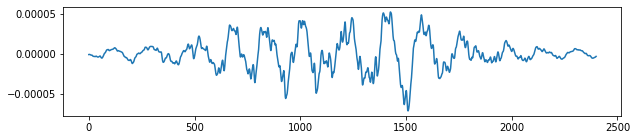

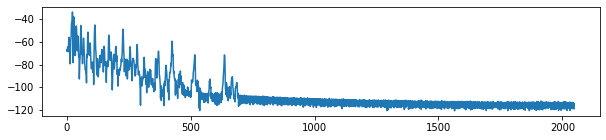

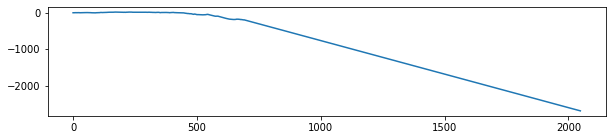

In [13]:
frames = list(sa.frames)
sframes = list(sa.spectral_frames)
sf = sframes[i]
sf.frame.plot()
sf.plot()
sf.plot_magnitudes()
sf.plot_phases();

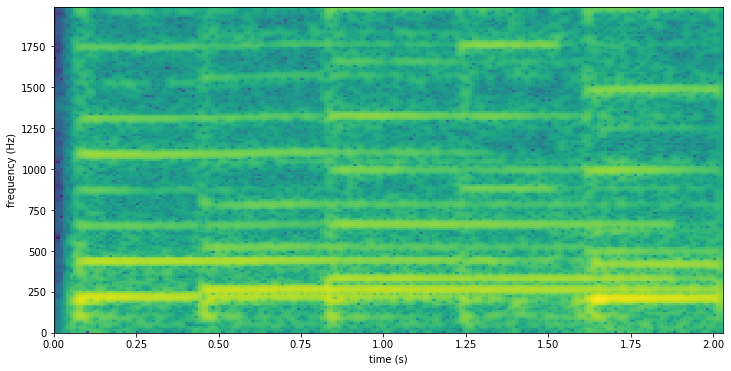

In [14]:
sa.plot_magnitudes(2000)

In [15]:
sma = SineModelAnalysis(s, 
                        fft_size=fft_size,
                        window_name='hamming',
                        frame_size=frame_size,
                        hop_size=hop_size,
                        peak_threshold=-80,
                        freq_dev_offset=5,
                        freq_dev_slope=0.001)

In [16]:
sma_frames = list(sma.sine_model_frames)
len(sma_frames)

204

In [17]:
len(sma.tracks)

108

In [18]:
pframes = list(sma.peak_frames)

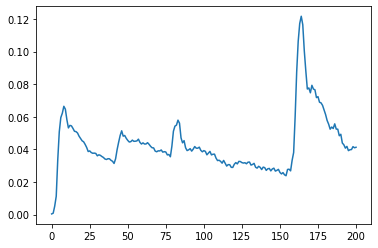

In [19]:
rms = lr.feature.rms(x, frame_length=frame_size, hop_length=hop_size)[0]
plt.plot(rms)

array([  8,  46,  83, 164])

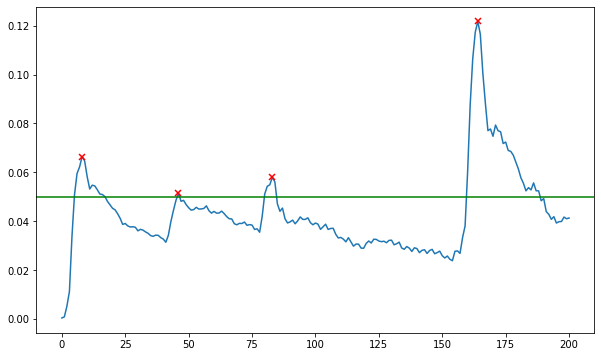

In [20]:
t = 0.05
peak_i = detect_peaks(rms, thresh=t)
peak_i = peak_i[[0, 2, 3, 4]]
plot_peaks(rms, peak_i, t=t)
peak_i

In [21]:
frames = list(sma.spectral_frames)

In [22]:
peak_threshold = -100

In [23]:
frame = frames[12]
peak_idx = detect_peaks(frame.magnitudes, peak_threshold)
mag = frame.magnitudes[peak_idx]
interp_idx, interp_mag = interpolate_peaks(frame.magnitudes, peak_idx)
freq = interp_idx * sr / fft_size
peaks = pd.DataFrame({'freq': freq,'mag': interp_mag})
len(peaks)

234

In [24]:
peaks.head()

,freq,mag
0,57.314263,-61.120350
1,111.185102,-51.219500
2,216.358025,-29.860466
3,276.005579,-61.091863
4,348.288222,-57.855651


In [25]:
f0 = 220
n_harmonics = 10

In [26]:
frame = frames[12]
def get_peaks(frame):
    peak_idx = detect_peaks(frame.magnitudes, peak_threshold)
    mag = frame.magnitudes[peak_idx]
    interp_idx, interp_mag = interpolate_peaks(frame.magnitudes, peak_idx)
    freq = interp_idx * sr / fft_size
    peaks = pd.DataFrame({'freq': freq,'mag': interp_mag})
    return peaks

In [27]:
def get_harms(peaks, f0, n_harmonics=10):
    if not len(peaks):
        return None
    harm_targets = f0 * np.arange(1, n_harmonics+1)
    harm_idx = abs(
        np.expand_dims(peaks.freq.values, -1) \
        - np.tile(harm_targets, (len(peaks),1))
    ).argmin(axis=0)
    harms = peaks.iloc[harm_idx].copy().reset_index().rename(columns={'index': 'pitch'})
    harms.insert(1, 'freq_targ', harm_targets)
    harms['error'] = harms.freq - harms.freq_targ
    return harms

In [28]:
note1_harms = []
for frame in frames:
    peaks = get_peaks(frame)
    harms = get_harms(peaks, 220)
#     if harms is not None:
#         print(len(harms))